In [21]:
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.data import Collector, VectorReplayBuffer
from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.trainer import offpolicy_trainer
from LCRL.utils import TensorboardLogger
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic, ActorProb
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

# NOTE: This notebook is used after training the reach-avoid value function via SAC

"""
    We can also learn the classical reach-avoid value function by using SAC under the classical annealed reach-avoid Bellman equation in arXiv:2112.12288:
    python run_training_sac.py --task ra_droneracing_Game-v6 --control-net 512 512 512 512 --disturbance-net 512 512 512 512 --critic-net 512 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160 --is-game-baseline True
"""

def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_droneracing_Game-v6')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.0)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512]*4) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512]*4) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512]*4) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=False) # True -> annealed reach-avoid Bellman equation, False -> our new reach-rl Bellman equation
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    parser.add_argument('--warm-start-path', type=str, default=None)
    # new sac params:
    parser.add_argument('--alpha', default = 0.2) 
    parser.add_argument('--auto-alpha', type=int, default=1)
    parser.add_argument('--alpha-lr', type=float, default=3e-4)
    args = parser.parse_known_args()[0]
    return args



args=get_args()


env = gym.make(args.task)
# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

args.action1_shape = env.action1_space.shape or env.action1_space.n
args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
args.max_action2 = env.action2_space.high[0]



train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    # report error:
    raise ValueError("Please provide critic_net!")

# critic = Critic(critic_net, device=args.device).to(args.device)
# critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
# import pdb; pdb.set_trace()
log_path = None

if args.is_game_baseline:
    from LCRL.policy import reach_avoid_game_SACPolicy_annealing as SACPolicy
    print("SAC under the Reach-Avoid annealed Bellman equation has been loaded!")
else:
    from LCRL.policy import reach_avoid_game_SACPolicy as SACPolicy
    print("SAC under the Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = ActorProb(
    actor1_net, 
    args.action1_shape, 
    device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
actor2 = ActorProb(
    actor2_net, 
    args.action2_shape, 
    device=args.device
).to(args.device)
actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)
if args.auto_alpha:
    target_entropy = -np.prod(env.action_space.shape)
    log_alpha = torch.zeros(1, requires_grad=True, device=args.device)
    alpha_optim = torch.optim.Adam([log_alpha], lr=args.alpha_lr)
    args.alpha = (target_entropy, log_alpha, alpha_optim)

policy = SACPolicy(
critic1,
critic1_optim,
critic2,
critic2_optim,
tau=args.tau,
gamma=args.gamma,
alpha = args.alpha,
exploration_noise= None,#GaussianNoise(sigma=args.exploration_noise), # careful!
deterministic_eval = True,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor2=actor2,
actor2_optim=actor2_optim,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, always true
    args.gamma)
    )
else:
    log_path = os.path.join(args.logdir, args.task, 'sac_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    # args.alpha, # always true
    args.gamma)
    )

log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



SAC under the Reach-RL Bellman equation has been loaded!


In [26]:
# data reloading module:
epoch_id = 20
envs = gym.make(args.task)
# check if the log path exists
# NOTE! You can define the log path in next line:
# log_path = ""

if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")



policy loaded!


In [3]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [27]:
from LCRL.data import Batch
def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math
from tqdm import tqdm

  0%|          | 0/260 [00:00<?, ?it/s]/tmp/ipykernel_24162/2624877537.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 260/260 [01:02<00:00,  4.14it/s]


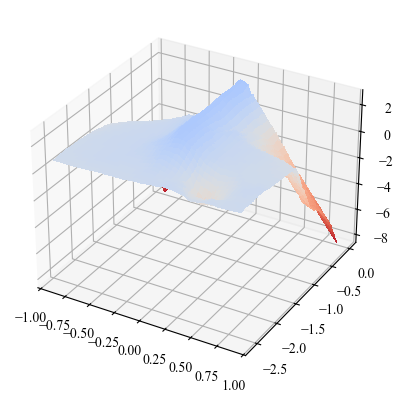

In [28]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'

x = np.arange(-0.9, 0.9, 0.01)
y = np.arange(-2.6, -0., 0.01)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))
ego_vx = 0.0
ego_vy = 0.7 # previous 0.8
ego_z = 0.0
ego_vz = 0.0


ad_x = 0.4
ad_vx = 0.0
ad_y = -2.2
ad_vy = 0.3
ad_z = 0.0
ad_vz = 0.0

X_V = X
Y_V = Y
for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            X[ii,jj], ego_vx,
            Y[ii,jj], ego_vy,
            ego_z, ego_vz,
            ad_x,  ad_vx,
            ad_y, ad_vy,
            ad_z, ad_vz
        ])
        V[ii,jj] = evaluate_V( tmp_point )
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,vmin= V.min(), vmax=-V.min(),
                        linewidth=0, antialiased=False)

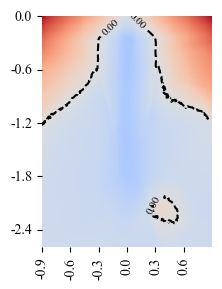

In [29]:
import seaborn as sns

x_interval = 30
y_interval = 60

fig, ax = plt.subplots(figsize=(2.2, 3))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax, vmin= V_flipped.min(), vmax=-V_flipped.min(),
            cbar=False,
            )

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+0.02, 1))

contours = ax.contour((X+0.9)*100, (Y+2.6)*100, V_flipped, levels=[0], colors="black", linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [60]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1


In [59]:
# Certification method 1: SOCP certification
def get_nominal_traj(state, horizon):
    env.reset(initial_state = state)
    nominal_traj = np.zeros((12, horizon+1))
    nominal_traj[:,0] = state
    nominal_act = np.zeros((6, horizon))
    constraint_list = np.zeros(horizon+1)
    reach_list = np.zeros(horizon)
    reached = False
    min_constraint = np.Inf
    success = False
    success_time = np.Inf
    for i in range(horizon):
        act = find_a(state)
        act = [act[0], act[1], act[2], 0, 0, 0]
        state, rew, _, _, info = env.step(act)
        nominal_traj[:,i+1] = state
        nominal_act[:,i] = act
        constraint_list[i] = info['constraint']
        reach_list[i] = rew
        min_constraint = min(min_constraint, info['constraint'])
        if rew > 0 and min_constraint > 0:
            success = True
            success_time = i
            break
    ego_traj = nominal_traj[3:7,:]
    return nominal_traj, ego_traj, nominal_act, constraint_list, reach_list, success, success_time


In [61]:
# defining the variables for the optimization problem for SOCP certification
from scipy import sparse
import clarabel

def qp_reach_avoid_variables(T, dt, epsilon_d, nx, nu, nd):
    num_vars = nx * (T+1) + nd * T
    print("number of variables: ", num_vars)
    A = np.eye(nx)
    B = np.zeros((nx, nu))
    D = np.zeros((nx, nd))
    A[0,1] = dt
    A[2,3] = dt
    A[4,5] = dt
    
    A[6,7] = dt    
    A[8,9] = dt
    A[10,11] = dt
    
    control_gain1 = 0.5
    B[1,0] = dt*control_gain1
    B[3,1] = dt*control_gain1
    B[5,2] = dt*control_gain1

    # we embed the feedback control for the adversary drone:
    K1 = np.array([3.1127])
    K2 = np.array([ 9.1704,   16.8205])
    x_star = [0.0, 0.0,
            0.0, 0.3,
            0.0, 0.0
            ]
    A[7,6] = -dt*K2[0]
    A[7,7] = 1 - dt*K2[1]
    
    A[9,9] = 1 - dt*K1[0]

    A[11,10] = -dt*K2[0]
    A[11,11] = 1 - dt*K2[1] # NOTE: we should also fix the offset term in the dynamics!
    
    D[7,0] = dt
    D[9,1] = dt
    D[11,2] = dt
    # now we consider the constraints
    num_eq = nx*T # Mx = N
    M = np.zeros((num_eq, num_vars))
    N = np.zeros((num_eq))
    num_ineq = (nx + nd*T) # double directions, Gx <= H
    # G = [G_x0, G_d]
    
    num_ine_x0 = nx
    G_x0 = np.zeros((num_ine_x0+1, num_vars))
    H_x0 = np.zeros((num_ine_x0+1))

    num_ine_d = nd*T
    G_d = np.zeros((num_ine_d+T, num_vars))
    H_d = np.zeros((num_ine_d+T))
    assert num_ineq == num_ine_x0 + num_ine_d
    cones = [
        clarabel.ZeroConeT(num_eq),
        clarabel.SecondOrderConeT(num_ine_x0+1)
    ]
    # warm start construction:
    # x0 bound
    G_x0[1:nx+1, 0:nx] = -np.eye(nx) # x0 <= upper
    # compute a sample trajectory and initialize the corresponding SOCP problem variables
    # For later certification, we will substitute different initial conditions and define their corresponding SOCP problems
    # This is just an initialization for the SOCP problem
    x0 = np.array([
    0., -0., # x, vx
    -3.0, 0.2,
    -0.0, 0,
    0.25, 0, # adversary
    -2., 0.2,
    0., 0
    ])
    _, ego_traj, nominal_act, constraint_list, reach_list, success, success_time = get_nominal_traj(x0, T)
    for t in range(T):
        # dynamics:
        # equality constraints
        M[t*nx : (t+1)*nx, t*nx:(t+1)*nx] = -A
        M[t*nx : (t+1)*nx, (t+1)*nx:(t+2)*nx] = np.eye(nx)
        M[t*nx : (t+1)*nx, (T+1)*nx + t*nd:(T+1)*nx + (t+1)*nd] = -D # -D d_t
        N[t*nx+1] = dt*nominal_act[0,t]
        N[t*nx+3] = dt*nominal_act[1,t]
        N[t*nx+5] = dt*nominal_act[2,t]
        # the adversary state feedback control:
        N[t*nx+7] = dt*(K2[0]*x_star[0]+K2[1]*x_star[1])
        N[t*nx+9] = dt*K1[0]*x_star[3]
        N[t*nx+11] = dt*(K2[0]*x_star[4]+K2[1]*x_star[5])
        G_d[t*(nd+1)+1:(t+1)*(nd+1), (T+1)*nx + t*nd:(T+1)*nx + (t+1)*nd] = -np.eye(nd)
        H_d[t*(nd+1)] = epsilon_d
        cones.append(clarabel.SecondOrderConeT(nd+1))
        
    G = np.concatenate([G_x0, G_d])
    H = np.concatenate([H_x0, H_d])
    zero_sparse_matrix = sparse.csr_matrix((num_vars, num_vars))
    reach_measures = [[np.zeros((num_vars)) for t in range(T)] for i in range(6)] # reachable means: reach_measure * x - reach_offset >0
    reach_offsets = np.zeros(6)
    reach_offsets[2] = -3. # we scale the reach_measure by 10, and therefore the offset should be scaled by 10. The original offset is -0.3
    reach_offsets[3] = -3.
    reach_offsets[4] = -3.
    reach_offsets[5] = -3.
    num_reach_check = len(reach_measures)
    for t in range(T):
        # reach_measures[0] checks whether y1 - y2 > 0
        reach_measures[0][t][t*nx + 2] = 1
        reach_measures[0][t][t*nx + 8] = -1
        
        # reach_measures[1] checks whether v1 - v2 > 0
        reach_measures[1][t][t*nx + 3] = 1
        reach_measures[1][t][t*nx + 9] = -1
        
        # reach_measures[2] checks whether 10 * x1 > 10 * 0.3
        reach_measures[2][t][t*nx + 0] = 10
        reach_measures[3][t][t*nx + 0] = -10
        reach_measures[4][t][t*nx + 4] = 10
        reach_measures[5][t][t*nx + 4] = -10
        
    prox_measures = [[np.zeros((num_vars, num_vars)) if i == 7 else np.zeros(num_vars) for t in range(T)] for i in range(1+1+5+1)] # we removed the speed check! 
    # proximity means: x' * prox_measure * x - prox_offset >0
    # NOTE the above prox_measures[2] represents the quadratic costs for collision avoidance checking!
    
    # they represent the safety cone constraint, speed constraint, and the proximity constraint, and 4 fence constraints
    # when we do certification, we will use the safety cone constraint proximity check to know the maximum flying height difference, and then use it to check proximity
    
    prox_offsets = np.zeros(len(prox_measures))
    prox_offsets[6] = -env.observation_space.high[3] # upper bound on the forward speed
    prox_offsets[7] = 0.2 # collision avoidance, depends on the maximum height difference!
    prox_offsets[0] = -0.1/2 # left fence
    prox_offsets[1] = -0.1/2 # right fence
    prox_offsets[2] = -0.1/2 # top fence
    prox_offsets[3] = -0.1/2 # bottom fence
    for t in range(T):
        prox_measures[0][t][t*nx+0] = 1 # left fence
        prox_measures[0][t][t*nx+2] = -1
        
        prox_measures[1][t][t*nx+0] = -1 # right fence
        prox_measures[1][t][t*nx+2] = -1
        
        prox_measures[2][t][t*nx+2] = -1 # upper fence
        prox_measures[2][t][t*nx+4] = -1
        
        prox_measures[3][t][t*nx+2] = -1 # lower fence
        prox_measures[3][t][t*nx+4] = 1
        
        prox_measures[4][t][t*nx + 10] = -1 # maximize the height difference between the adversary drone and the ego drone
        prox_measures[4][t][t*nx + 4] = 1
        prox_measures[5][t][t*nx + 10] = 1 # maximize the height difference between the adversary drone and the ego drone
        prox_measures[5][t][t*nx + 4] = -1
        
        prox_measures[6][t][t*nx + 3] = -1 # speed constraint, maximize the forward speed and check whether it accelerates too much
        
        prox_measures[7][t][np.ix_(t*nx+np.array([0,2, 6,8]), t*nx+np.array([0,2, 6,8]))] = np.eye(4)
        prox_measures[7][t][np.ix_(t*nx+np.array([0,2]), t*nx+np.array([6,8]))] = -np.eye(2)
        prox_measures[7][t][np.ix_(t*nx+np.array([6,8]), t*nx+np.array([0,2]))] = -np.eye(2)
        prox_measures[7][t] = sparse.csr_matrix(prox_measures[7][t])
        
        
    return G_x0, H_x0, G_d, H_d, M, N, G, H, ego_traj, nominal_act, constraint_list, reach_list, success, success_time, num_vars, num_eq, num_ineq,cones, zero_sparse_matrix, reach_measures, reach_offsets, num_reach_check, prox_measures, prox_offsets


In [62]:
import clarabel
from scipy import sparse
from time import time
def qp_reach_avoid_checking(delta_x, delta_d, x0, T, dt, M,N,G,H_x0,H_d, num_eq, num_ineq,cones, num_vars,
                            prox_measures, prox_offsets, reach_measures, reach_offsets, zero_sparse_matrix, verbose = False):
    _, ego_traj, nominal_act, constraint_list, reach_list, success, success_time = get_nominal_traj(x0, T)
    if not success:
        print("not success") if verbose else None
        return False, None
    print("x0: ", x0) if verbose else None
    print("success time: ", success_time) if verbose else None
    # we consider dynamics as equality constraints and inequality constraints:
    # x_{t+1} - A x_t + D d_t = B u_t
    # we construct those constraints:
    for t in range(T):
        N[t*nx+1] = dt*nominal_act[0,t]
        N[t*nx+3] = dt*nominal_act[1,t]
        N[t*nx+5] = dt*nominal_act[2,t]
    H_x0[0] = delta_x
    H_x0[1:nx+1] = -x0
    # H_x0[:nx] = x0 + delta_x*np.ones(nx)
    # H_x0[nx:] = -(x0 - delta_x*np.ones(nx))
    H = np.concatenate([H_x0, H_d])

    settings = clarabel.DefaultSettings()
    settings.verbose = False
    A = sparse.vstack([M, G]).tocsc()*10 # equality constraints and inequality constraints
    b = np.concatenate([N, H])*10 # offset of the equality constraints and inequality constraints
    q = np.zeros(num_vars)
    # solver = clarabel.DefaultSolver(P, q, A, b, cones, settings)
    # tmp = solver.solve()
    num_prox_check = len(prox_measures)
    num_reach_check = len(reach_measures)
    proximity_list = np.zeros(num_prox_check*T)
    reach_list = np.zeros(num_reach_check*T)
    solver_status = []
    max_height_diff = 0
    # checking reach avoid
    for t in range(T):
        for i in range(num_prox_check):
            # i = 0: max height difference
            if i == 7:
                # import pdb; pdb.set_trace()
                solver = clarabel.DefaultSolver(prox_measures[i][t], q, A, b, cones, settings)
            else:
                solver = clarabel.DefaultSolver(zero_sparse_matrix, prox_measures[i][t], A, b, cones, settings)
            # print(A.shape)
            # print(b.shape)
            tmp = solver.solve()
            # print(tmp.status) if tmp.status != "Solved" else None
            if i == 7: # max height difference + safety cone constraints!
                proximity_list[t*num_prox_check+i] = tmp.obj_val - 0.5*((1+max_height_diff)*prox_offsets[i])**2 
            else:
                proximity_list[t*num_prox_check+i] = tmp.obj_val - prox_offsets[i]
            
            if i == 4:
                max_height_diff = np.abs(tmp.obj_val)
            if i == 5:
                max_height_diff = max(np.abs(tmp.obj_val), max_height_diff)

                
            solver_status.append(tmp.status)
            
            if str(tmp.status) != "Solved":
                print(tmp.status)
                return False, solver_status
            if proximity_list[t*num_prox_check+i] < 0 and i != 4 and i != 5:
                print(tmp.x) if verbose else None
                print("proximity failed at t = {} at i = {} with value = {}".format(t, i, proximity_list[t*num_prox_check+i])) if verbose else None
                return False, solver_status
        
        for i in range(num_reach_check):
            # import pdb; pdb.set_trace()
            solver = clarabel.DefaultSolver(zero_sparse_matrix, reach_measures[i][t], A, b, cones, settings)
            tmp = solver.solve()
            tmp_status = tmp.status
            solver_status.append(tmp_status)
            if str(tmp.status) != "Solved":
                print(tmp.status)
                return False, solver_status
            reach_list[t*num_reach_check+i] = tmp.obj_val - reach_offsets[i]
            solver_status.append(tmp.status)
            if reach_list[t*num_reach_check+i] < 0:
                print("reach failed at t = {} at i = {}".format(t, i)) if verbose else None
                break
            
        if reach_list[t*num_reach_check:(t+1)*num_reach_check].min() > 0:
            return True, solver_status
        
    return False, solver_status



number of variables:  462


100%|██████████| 52/52 [02:03<00:00,  2.38s/it]


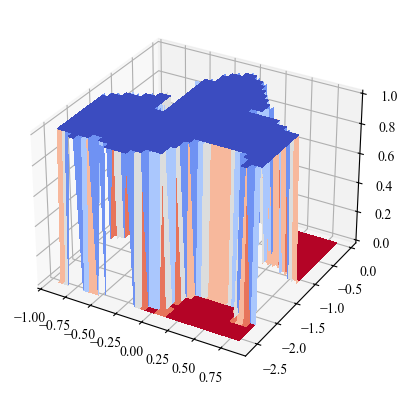

In [63]:
import matplotlib.pyplot as plt
from tqdm import tqdm
epsilon_d = 0.1
epsilon_x = 0.05
gamma = args.gamma
T = 30
dt = 0.1
nx = 12
nu = 3
nd = 3
G_x0, H_x0, G_d, H_d, M, N, G, H, ego_traj, nominal_act, constraint_list, reach_list, success, success_time, num_vars, num_eq, num_ineq,cones, zero_sparse_matrix, reach_measures, reach_offsets, num_reach_check, prox_measures, prox_offsets = qp_reach_avoid_variables(T, dt, epsilon_d, nx, nu, nd)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = np.arange(-0.9, 0.9, epsilon_x)
y = np.arange(-2.6, -0., epsilon_x)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V_qp = np.zeros((X.shape))
status_list = [[[] for i in range(size_x)] for j in range(size_y)]
for ii in tqdm(range(V_qp.shape[0])):
    for jj in range(V_qp.shape[1]):
        tmp_point = np.array([
            X[ii,jj], ego_vx,
            Y[ii,jj], ego_vy,
            ego_z, ego_vz,
            ad_x,  ad_vx,
            ad_y, ad_vy,
            ad_z, ad_vz
        ])
        Done, tmp = qp_reach_avoid_checking(epsilon_x, epsilon_d, tmp_point, T, dt, M,N,G,H_x0,H_d, num_eq, num_ineq,cones, num_vars,
                            prox_measures, prox_offsets, reach_measures, reach_offsets, zero_sparse_matrix, verbose = False)
        status_list[ii][jj] = tmp
        if Done == True:
            V_qp[ii,jj] = 1
        else:
            V_qp[ii,jj] = 0
surf = ax.plot_surface(X, Y, V_qp, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=False)


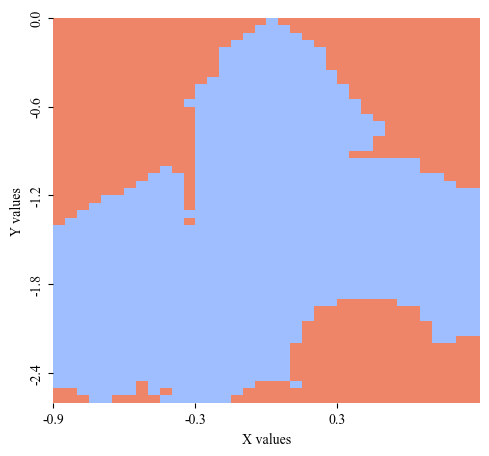

In [64]:
import seaborn as sns

x_interval = 12
y_interval = 12

fig, ax = plt.subplots(figsize=(5.5, 5) )
Vqp_flipped = np.flipud(V_qp)
sns.heatmap(Vqp_flipped, annot=False, cmap=cm.coolwarm_r,alpha = 1,vmin=-0.4,  vmax = 1.6 , ax=ax,cbar=False,
            )
ax.set_xlabel('X values')
ax.set_ylabel('Y values')
x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)
ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+0.1, 1) )
# contours = ax.contour(X*21, Y*20, V_flipped, levels=[0], colors='black', linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
# change the plot size
plt.show()


In [65]:
# Certification method 2: Lipschitz certification
certification_gamma = args.gamma
def beta(T, Lf, Ld, epsilon_x, epsilon_d):
    tmp = 0
    # gamma = args.gamma
    tmp = Lf**T * epsilon_x + (1-Lf**(T))/(1-Lf)*Ld * epsilon_d #* Lf
    return tmp * certification_gamma**T
def calibrate_V(env, state, horizon,  verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    state_traj[:,0] = state
    env.reset(initial_state = state)
    
    # gamma = args.gamma
    value_list = np.array([])
    constraint_list = np.array([])
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        # modify action
        action = np.array([action[0], action[1], action[2], 0, 0, 0])
        tmp, rew, _, _, info = env.step(action)
        state_traj[:,t+1] = tmp
        tmp_constraint = info["constraint"]*certification_gamma**t - alphaC_list[t]
        if tmp_constraint < 0:
            return -1e-3
        constraint_list = np.append(constraint_list, tmp_constraint)
        tmp_value = np.min([ certification_gamma**t * rew - alphaR_list[t], 
                            np.min(constraint_list) ]) # TODO: program the empirical value function
        if tmp_value > 0:
            return 1
        value_list = np.append(value_list, tmp_value)
    empirical_value = max(value_list)
    empirical_value = 0 if empirical_value < 0 else 1
    return empirical_value


Lf = 1.05125
# Lf = 1.06
Lc=20
Lr=10
Ld = 0.1
epsilon_d = 0.1
epsilon_x = 0.05
gamma = 0.95
horizon = 20
alphaC_list = np.zeros(horizon)
alphaR_list = np.zeros(horizon)
for t in range(horizon):
    alphaC_list[t] = Lc*beta(t, Lf,Ld, epsilon_x, epsilon_d)
    alphaR_list[t] = Lr*beta(t, Lf,Ld, epsilon_x, epsilon_d)
    

100%|██████████| 52/52 [00:06<00:00,  8.27it/s]


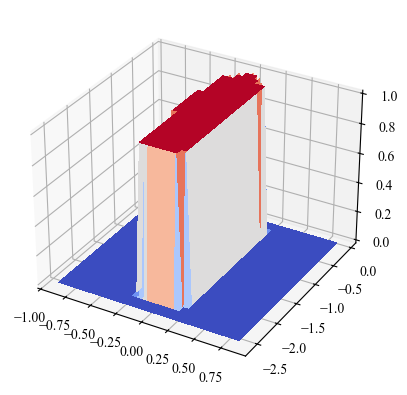

In [66]:
# plot the calibrated value function
from tqdm import tqdm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
x = np.arange(-0.9, 0.9, 0.05)
y = np.arange(-2.6, 0, 0.05)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V_lp = np.zeros((X.shape))
x2 = 0.4
y2 = -1.5
z2 = 0.2
velocity = 0.5
distance = math.sqrt(x2**2 + y2**2 + z2**2)
vx2 = -x2/(distance)*velocity
vy2 = -y2/(distance)*velocity
vz2 = -z2/(distance)*velocity
for ii in tqdm(range(V_lp.shape[0])):
    for jj in range(V_lp.shape[1]):
        tmp_point = torch.tensor([
            X[ii,jj], ego_vx,
            Y[ii,jj], ego_vy,
            ego_z, ego_vz,
            ad_x, ad_vx,
            ad_y, ad_vy,
            ad_z, ad_vz
        ])
        V_lp[ii,jj] = calibrate_V(env, tmp_point.numpy(), horizon, )
        
surf = ax.plot_surface(X, Y, V_lp, cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

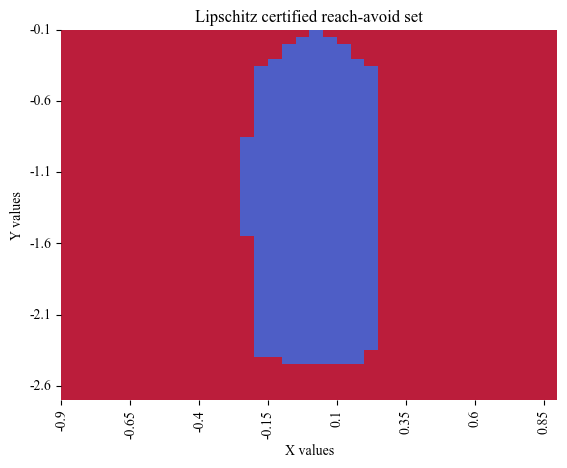

In [67]:
import seaborn as sns

x_interval = 5
y_interval = 10

fig, ax = plt.subplots()
Vlp_flipped = np.flipud(V_lp)
sns.heatmap(Vlp_flipped, annot=False, cmap=cm.coolwarm_r,alpha = 0.9, ax=ax,cbar=False,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))

ax.set_title('Lipschitz certified reach-avoid set')
ax.set_xlabel('X values')
ax.set_ylabel('Y values')

x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval], 1))

ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
# change the plot size
plt.show()


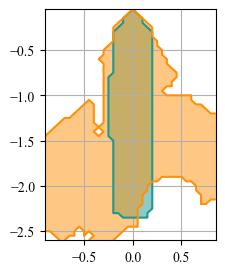

In [68]:
import matplotlib.colors as colors

plt.figure(figsize=(2.2, 3)
        )
binary_V = np.zeros(V_lp.shape)
binary_V[V_lp > 0] = 1
binary_Vqp = np.zeros(V_qp.shape)
binary_Vqp[V_qp > 0] = 1
plt.contour(X,Y,binary_V, levels=[1 - 1e-6], colors = color_list[2])
plt.contour(X,Y,binary_Vqp, levels=[1 - 1e-6], colors = color_list[0])
plt.contourf(X,Y,binary_V, levels=[1 - 1e-6, 1], colors = color_list[2], alpha = 0.5, 
        )# colors='red'

plt.contourf(X,Y,binary_Vqp,levels=[1 - 1e-6, 1], colors = color_list[0],alpha = 0.5, 
        )

plt.grid()


In [15]:
"""
success rate is computed by recording the number of initial states that can be maintained within the target set for 100 steps
"""
from LCRL.data import Batch
from tqdm import tqdm

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    act[3:] = np.random.uniform(-1, 1, size = 3)
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic1(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

n_dim = env.observation_space.shape[0]
def roll_out_traj(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    
    state_traj[:,0] = state
    env.reset(initial_state = state)
    safe_reaching_time = np.inf
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        rand_disturbance = np.random.uniform(low = -1, high = 1, size = (3,))
        action = np.array([action[0], action[1], action[2], rand_disturbance[0], rand_disturbance[1], rand_disturbance[1]])
        tmp, rew, _, _, info = env.step(action)
        
        state_traj[:,t+1] = tmp
        if rew > 0 and t<=horizon-2 and info["constraint"] > 0:
            if t>1 and verbose:
                print("success at time = {}!".format(t))
            return state_traj[:,:t+1], True, rand_disturbance

        if info["constraint"] < 0:
            print("constraint violated!") if verbose else None
            return state_traj[:,:t+1], False, rand_disturbance
            break
        
        if state_traj[2,t+1] > 0 or state_traj[8,t+1] > 0:
            print("A Drone passed frame!") if verbose else None
            return state_traj[:,:t+1], False, rand_disturbance
            break
    return state_traj, False, rand_disturbance

num_samples = 100
sampled_states = np.zeros((n_dim,num_samples))
num_success = 0
horizon = 300
high = np.array([  
                0.7,  0.3,  -1.5,  0.9,  0.7,  0.3,
                0.7,  0.3,  -1.5,  0.9,  0.7,  0.3,
                ], dtype=np.float32) # x1 vx1 y1 vy1 z1 vz1          x2 vx2 y2 vy2 z2 vz2
low  = np.array([  
                -0.7, -0.3, -3, 0.2, -0.7, -0.3,
                -0.7, -0.3, -3, 0.2, -0.7, -0.3,
                ], dtype=np.float32)

list_of_failure_states = []
list_of_success_states = []
for ii in tqdm(range(num_samples)):
    sampled_initial_state = np.random.uniform(low = low, high = high)
    tmp = envs.reset(initial_state = sampled_initial_state)
    sampled_states[:,ii] = tmp[0]
    while evaluate_V(sampled_states[:,ii]) < 0:
        sampled_initial_state = np.random.uniform(low = low, high = high)
        tmp = envs.reset(initial_state = sampled_initial_state)
        sampled_states[:,ii] = tmp[0]
    traj, success,_ = roll_out_traj(envs, sampled_states[:,ii], horizon, verbose = False)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(sampled_states[:,ii])
    else:
        list_of_failure_states.append(sampled_states[:,ii])
        continue
num_success/num_samples

100%|██████████| 100/100 [00:02<00:00, 49.59it/s]


0.96

success at time = 17!


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 520/520 [00:06<00:00, 82.12it/s]
/tmp/ipykernel_16740/3819624115.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5,
/tmp/ipykernel_16740/3819624115.py:54: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
100%|██████████| 18/18 [00:06<00:00,  2.83it/s]


(-0.95, 0.95)

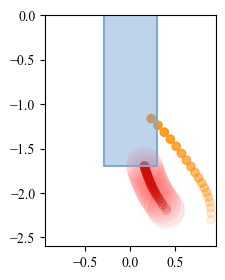

In [51]:
#9748
# note that we need to load epoch = 1600!!!!!!!!
# plot the target set too!
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
from tqdm import tqdm
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'))
initial_state = np.array([
    0.9, ego_vx, # x, vx
    -2.3, ego_vy,
    ego_z, ego_vz,
    ad_x, ad_vx,
    ad_y, ad_vy,
    ad_z, ad_vz
])
horizon = 300
traj,_,rand_disturbance = roll_out_traj(envs, initial_state, horizon, verbose=True)
fig, ax = plt.subplots(figsize=(2.2,3))
min_x = -0.6
max_x = 0.6
min_y = -2.8
max_y = -1.4
alphas = np.linspace(0.1, 1.0, len(traj[0,:]))
ax.scatter(traj[0,:], traj[2,:],  color = color_list[0], alpha = alphas ) #"o", color="#314cd4",  label = "ego")
ax.scatter(traj[6,:], traj[8,:],  color = color_list[4], alpha = alphas) #'o', color="#EA3323",label = "adversary")


def target_set(env, X, Y, tmp_point = np.array([
    0, 0.,-1, 0.8,-0.0, 0,0.3,  0,-2.2, 0.3,0., 0
])):
    reward = np.zeros((X.shape))
    for ii in tqdm(range(reward.shape[0])):
        for jj in range(reward.shape[1]):
            tmp_point[0], tmp_point[2] = X[ii,jj], Y[ii,jj]
            env.reset(initial_state = tmp_point)
            reward[ii,jj] = 1 if env.step([0,0,0,0,0,0])[1]>=0 else 0
    return reward

plt.rcParams["contour.linewidth"]=1.5

for j in tqdm(range(traj.shape[1])):    
    # plot the target set
    if j == traj.shape[1]-1:
        x = np.arange(-0.9, 0.9, 0.005)
        y = np.arange(-2.6, 0, 0.005)
        X, Y = np.meshgrid(x, y)
        reward = target_set(envs, X, Y, traj[:,j])
        plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1],  colors = "#80A8D6", alpha = 0.5, 
                    label = "target set"
                    # hatches=['//']
                    )
        plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = "#80A8D6", alpha=1, label = "target set")
    ax.add_patch(matplotlib.patches.Circle((traj[6,j], traj[8,j]), 0.2, color='r', fill=True, alpha=0.05))
ax.set_ylim([-2.6, 0])
ax.set_xlim([-0.95, 0.95])